# Regression with Decision Trees

### Imports

In [1]:
import sklearn
from sklearn import datasets
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

c:\Users\Eric\anaconda3\envs\ANLY501\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Load Data

In [2]:

df = pd.read_csv('../../data/01-modified-data/hours_worked_(by_sex_and_by_occupation)_final.csv')

## drop unneeded rows
df = df[df['sex'] != 'B']
#df = df[df['Category'] != 'Total']

In [3]:
# convert from long to wide
df = pd.pivot(df, index=['Category', 'sex'], columns=['Measure'], values='Value').reset_index()

In [4]:
# create numerical representations for occupation categories
df['Category_num'] = 0
df.iloc[0:2, 7] = 1
df.iloc[2:4, 7] = 2
df.iloc[4:6, 7] = 3
df.iloc[6:8, 7] = 4
df.iloc[8:, 7] = 5

In [5]:
# convert sex to numerical (0 = m, 1 = f)
df['sex'] = df['sex'].replace('F', 1).replace('M', 0)

In [6]:
df.rename(columns={'Average hrs worked among all workers' : 'Target'}, inplace=True)

### Separate Predictor and Response Variables

In [7]:
X = df.iloc[:, [1,3,4,5,6,7]]
Y = df['Target']

### Normalization

In [8]:
X=0.1+(X-np.min(X,axis=0))/(np.max(X,axis=0)-np.min(X,axis=0))
Y=0.1+(Y-np.min(Y,axis=0))/(np.max(Y,axis=0)-np.min(Y,axis=0))

### Numerical EDA

In [9]:
df['Target'].value_counts(ascending=True)

38.6    1
42.0    1
37.7    1
40.7    1
35.7    1
39.5    1
33.0    1
37.1    1
36.6    2
40.6    2
Name: Target, dtype: int64

### Multivariable Pair Plot

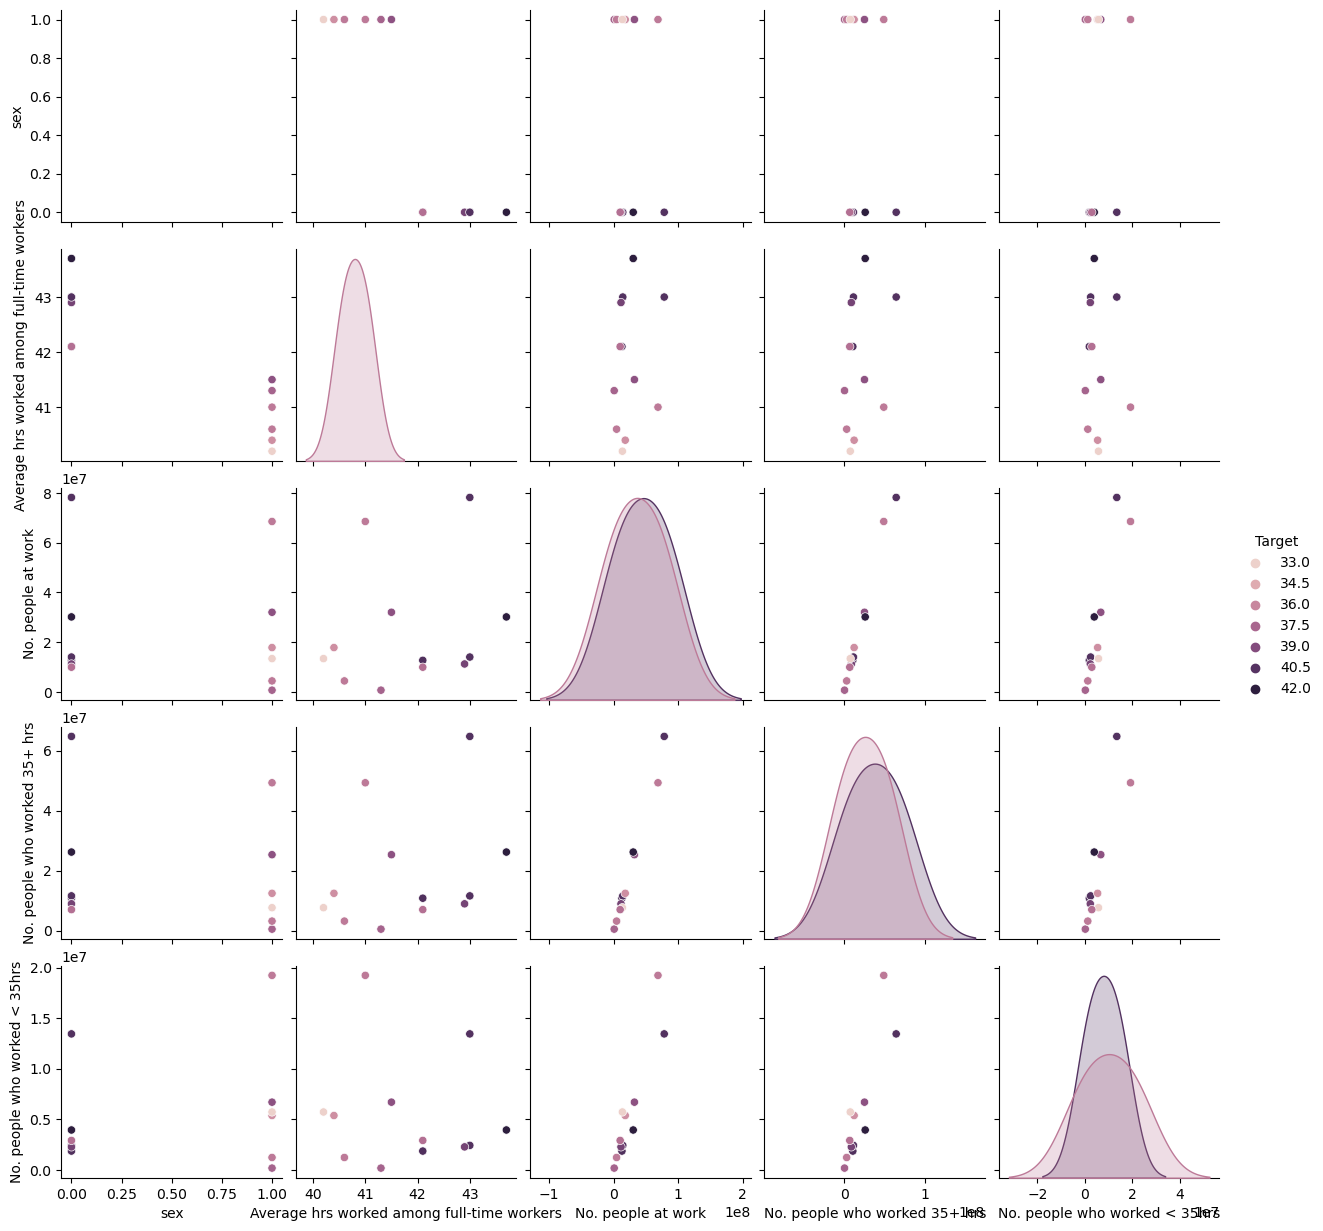

In [10]:
sns.pairplot(df.iloc[:, 1:7], hue='Target')
plt.show()

### Correlation

In [11]:
corr = X.corr()
print(corr)	

Measure                                              sex  \
Measure                                                    
sex                                         1.000000e+00   
Average hrs worked among full-time workers -8.849447e-01   
No. people at work                         -6.824094e-02   
No. people who worked 35+ hrs              -1.371153e-01   
No. people who worked < 35hrs               1.806626e-01   
Category_num                               -7.447602e-17   

Measure                                     Average hrs worked among full-time workers  \
Measure                                                                                  
sex                                                                          -0.884945   
Average hrs worked among full-time workers                                    1.000000   
No. people at work                                                            0.208849   
No. people who worked 35+ hrs                                        

### Correlation Matrix Heatmap

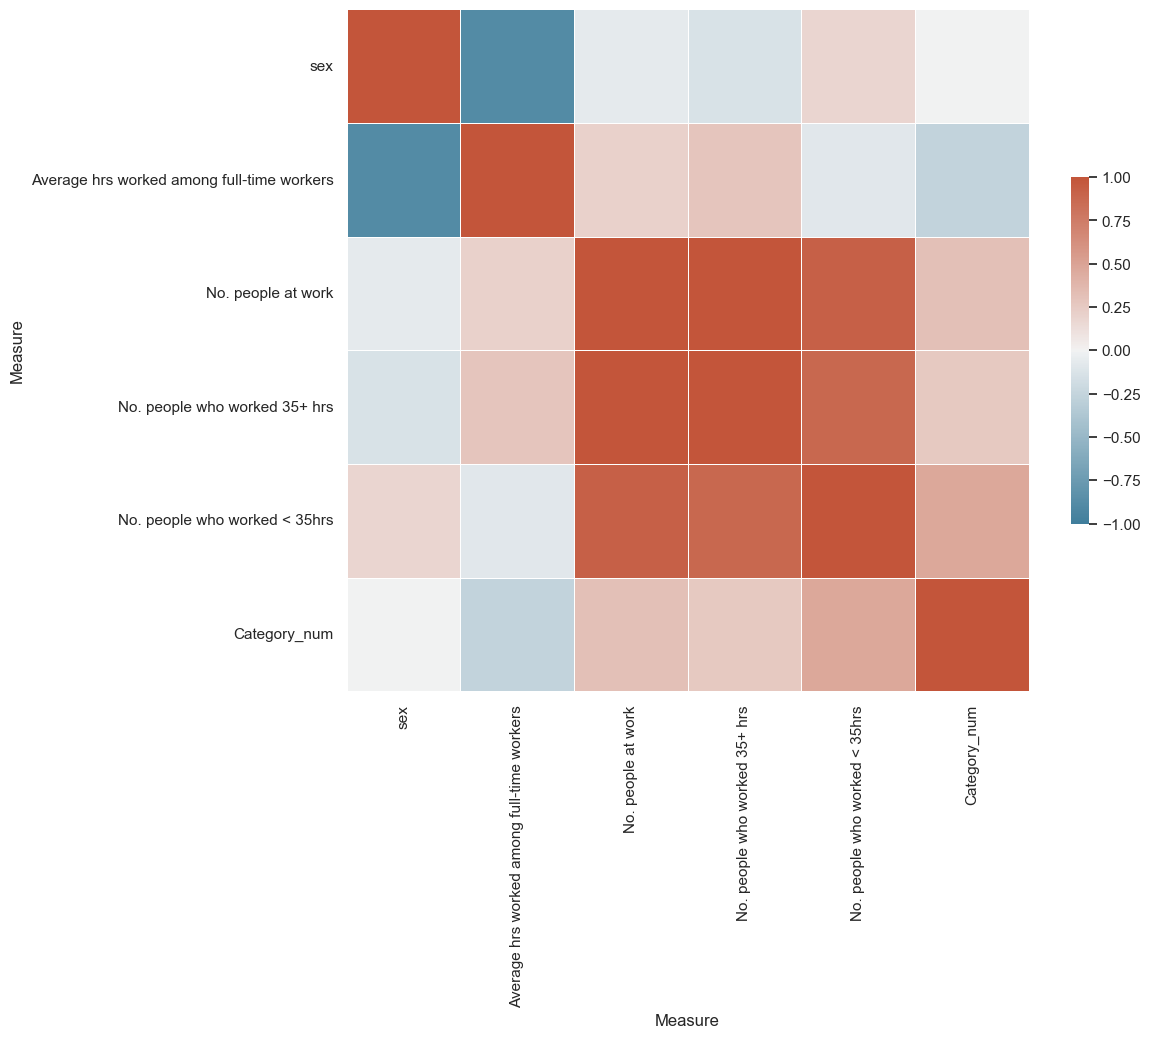

In [12]:
sns.set_theme(style="white")
f, ax = plt.subplots(figsize=(11, 9))  # Set up the matplotlib figure
cmap = sns.diverging_palette(230, 20, as_cmap=True) 	# Generate a custom diverging colormap
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr,  cmap=cmap, vmin=-1, vmax=1, center=0,
        square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show();

### Remove Correlated Features

In [13]:
X.columns

Index(['sex', 'Average hrs worked among full-time workers',
       'No. people at work', 'No. people who worked 35+ hrs',
       'No. people who worked < 35hrs', 'Category_num'],
      dtype='object', name='Measure')

In [14]:
X.drop(X.columns[[1,2,4]], axis=1, inplace=True)

### Split Data

In [15]:
from sklearn.model_selection import train_test_split
test_ratio=0.2
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=test_ratio, random_state=0)

In [16]:
print(type(x_train), x_train.shape)
print(type(y_train), y_train.shape)
print(type(x_test), x_test.shape)
print(type(y_test), y_test.shape)

<class 'pandas.core.frame.DataFrame'> (9, 3)
<class 'pandas.core.series.Series'> (9,)
<class 'pandas.core.frame.DataFrame'> (3, 3)
<class 'pandas.core.series.Series'> (3,)


### Hyperparameter Tuning

In [17]:
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor


# HYPER PARAMETER SEARCH FOR OPTIMAL NUMBER OF NEIGHBORS 
hyper_param=[]
train_error=[]
test_error=[]

# LOOP OVER HYPER-PARAM
for i in range(1,11):
    # INITIALIZE MODEL 
    model = DecisionTreeRegressor(max_depth=i)

    # TRAIN MODEL 
    model.fit(x_train,y_train)

    # OUTPUT PREDICTIONS FOR TRAINING AND TEST SET 
    yp_train = model.predict(x_train)
    yp_test = model.predict(x_test)

    # shift=1+np.min(y_train) #add shift to remove division by zero 
    err1=mean_absolute_error(y_train, yp_train) 
    err2=mean_absolute_error(y_test, yp_test) 
    
    # err1=100.0*np.mean(np.absolute((yp_train-y_train)/y_train))
    # err2=100.0*np.mean(np.absolute((yp_test-y_test)/y_test))

    hyper_param.append(i)
    train_error.append(err1)
    test_error.append(err2)

    print("hyperparam =",i)
    print(" train error:",err1)
    print(" test error:" ,err2)
    print(" error diff:" ,abs(err2-err1))

hyperparam = 1
 train error: 0.15596707818930045
 test error: 0.46049382716049375
 error diff: 0.3045267489711933
hyperparam = 2
 train error: 0.08765432098765434
 test error: 0.2777777777777778
 error diff: 0.19012345679012344
hyperparam = 3
 train error: 0.018930041152263415
 test error: 0.262962962962963
 error diff: 0.2440329218106996
hyperparam = 4
 train error: 0.0012345679012345883
 test error: 0.262962962962963
 error diff: 0.2617283950617284
hyperparam = 5
 train error: 0.0
 test error: 0.262962962962963
 error diff: 0.262962962962963
hyperparam = 6
 train error: 0.0
 test error: 0.2444444444444445
 error diff: 0.2444444444444445
hyperparam = 7
 train error: 0.0
 test error: 0.2444444444444445
 error diff: 0.2444444444444445
hyperparam = 8
 train error: 0.0
 test error: 0.2444444444444445
 error diff: 0.2444444444444445
hyperparam = 9
 train error: 0.0
 test error: 0.262962962962963
 error diff: 0.262962962962963
hyperparam = 10
 train error: 0.0
 test error: 0.244444444444444

### Convergence Plot

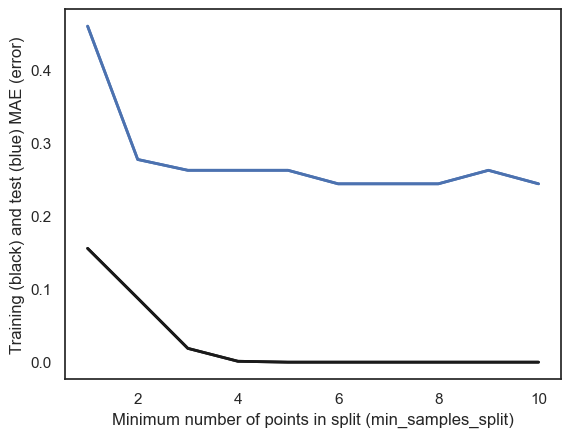

In [26]:
plt.plot(hyper_param,train_error ,linewidth=2, color='k')
plt.plot(hyper_param,test_error ,linewidth=2, color='b')

plt.xlabel("Minimum number of points in split (min_samples_split)")
plt.ylabel("Training (black) and test (blue) MAE (error)")

plt.show();

### Re-train w/ Optimal Parameters

In [28]:
# INITIALIZE MODEL 
model = DecisionTreeRegressor(max_depth=2)
model.fit(x_train,y_train)                     # TRAIN MODEL 


# OUTPUT PREDICTIONS FOR TRAINING AND TEST SET 
yp_train = model.predict(x_train)
yp_test = model.predict(x_test)

err1=mean_absolute_error(y_train, yp_train) 
err2=mean_absolute_error(y_test, yp_test) 
    
print(" train error:",err1)
print(" test error:" ,err2)

 train error: 0.08765432098765434
 test error: 0.2777777777777778


### Parity Plot

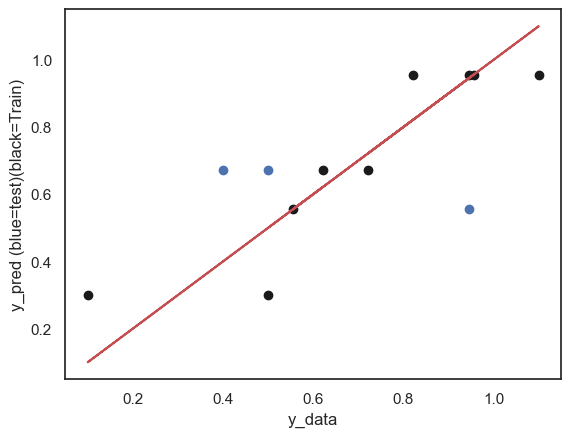

In [29]:
plt.plot(y_train,yp_train ,"o", color='k')
plt.plot(y_test,yp_test ,"o", color='b')
plt.plot(y_train,y_train ,"-", color='r')

plt.xlabel("y_data")
plt.ylabel("y_pred (blue=test)(black=Train)")

plt.show();

### Plot Tree

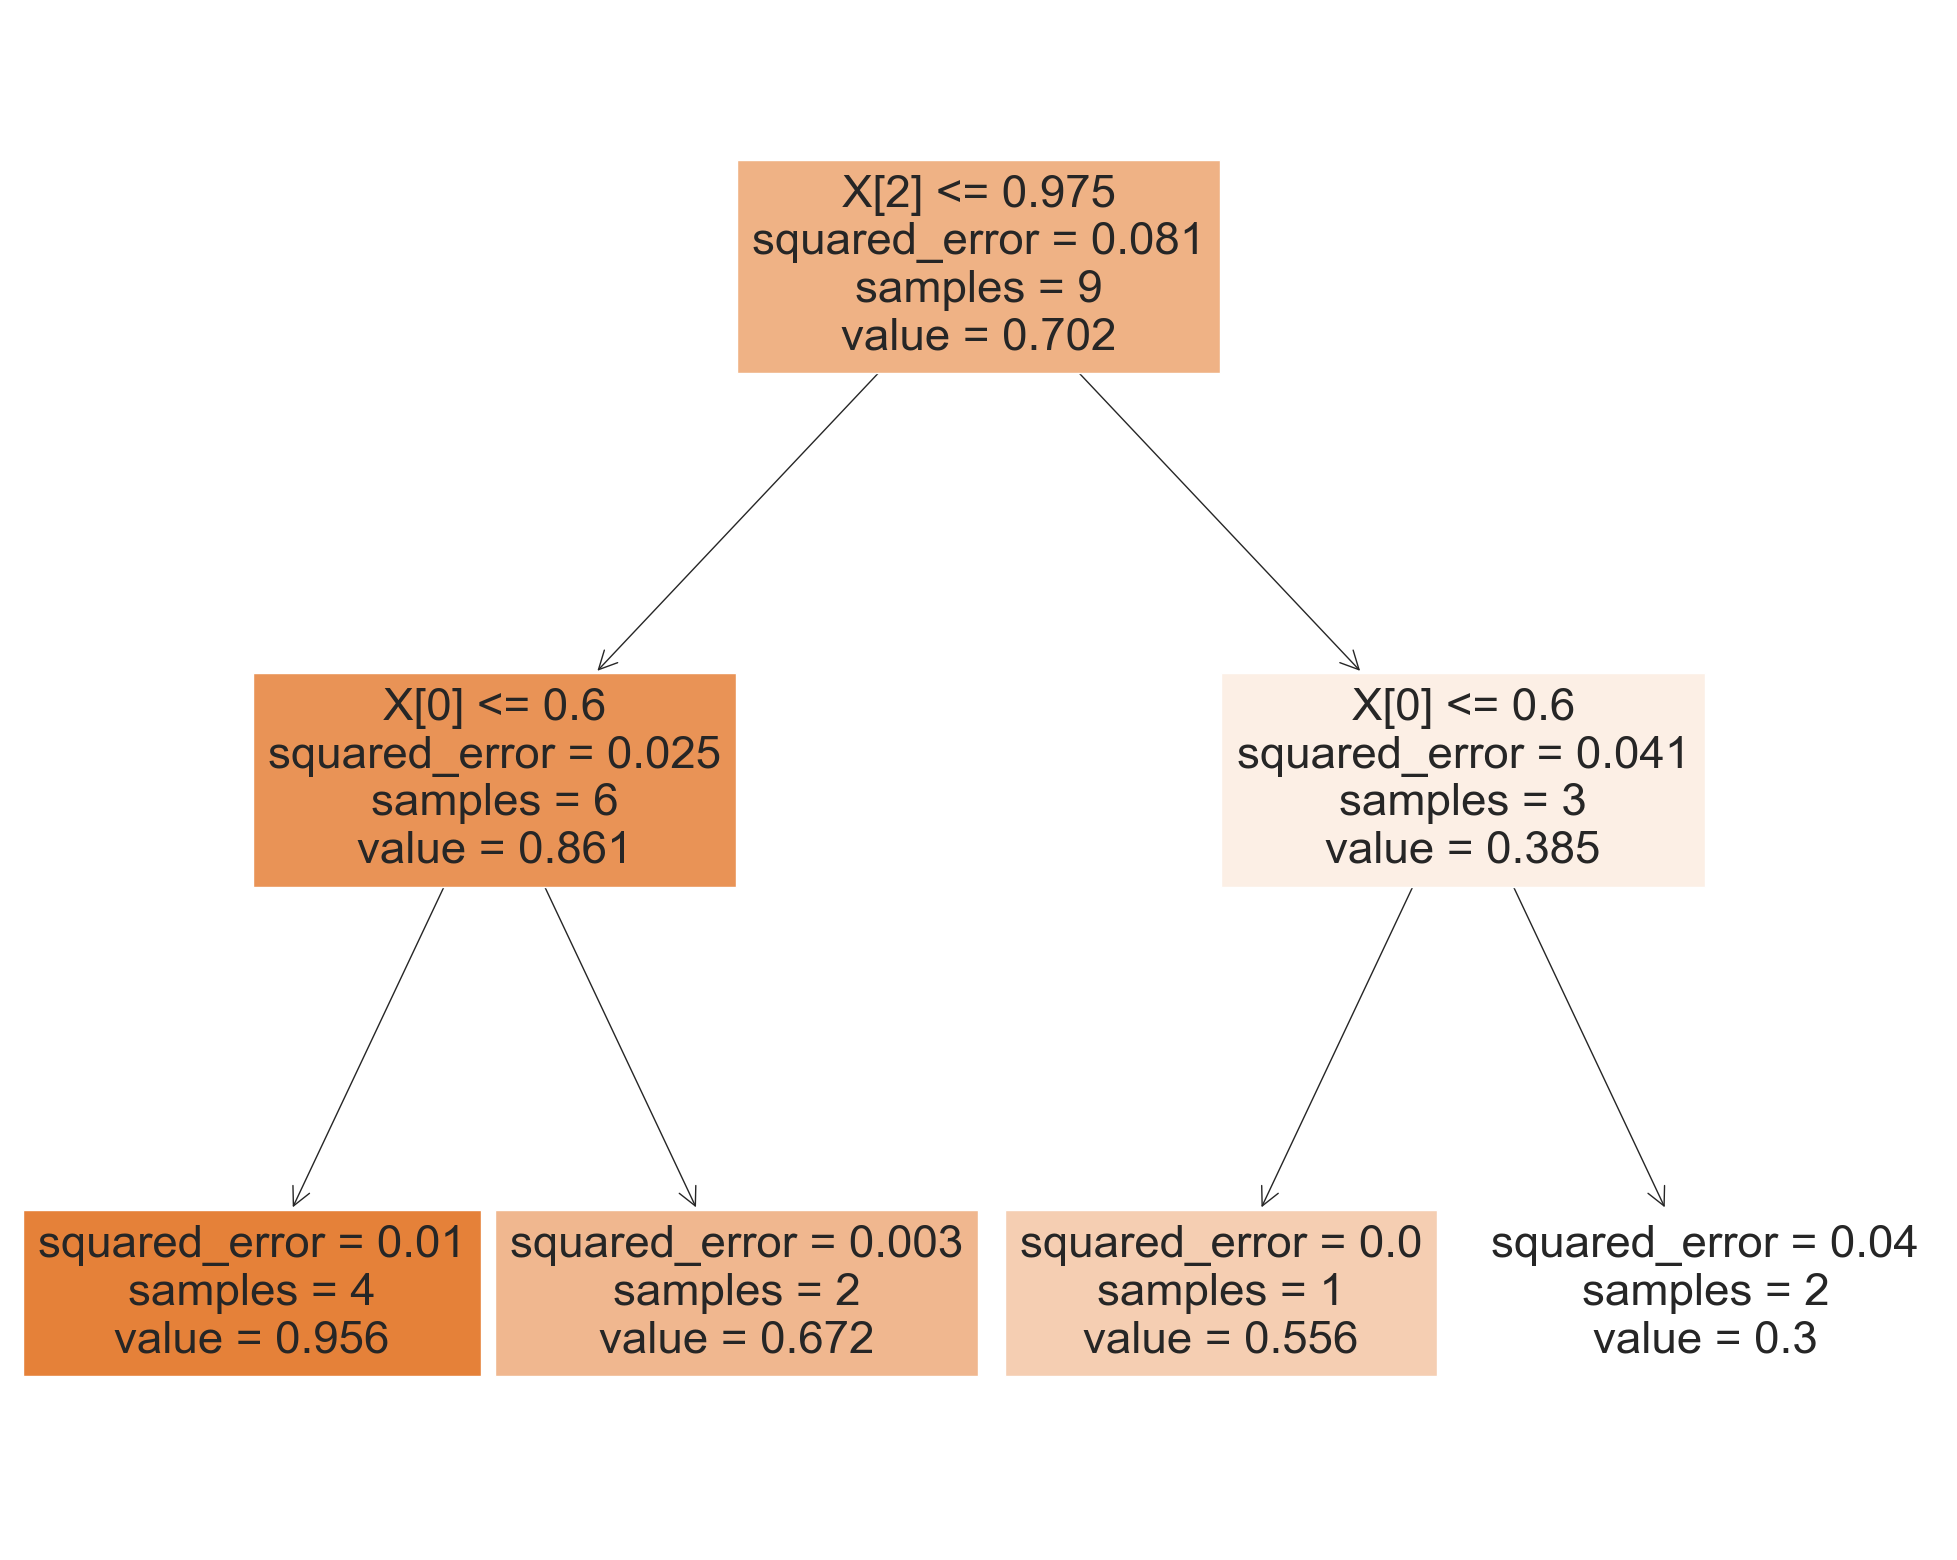

In [30]:
from sklearn import tree
def plot_tree(model):
    fig = plt.figure(figsize=(25,20))
    _ = tree.plot_tree(model, 
                    filled=True)
    plt.show()
plot_tree(model)

 train error: 23.337452377286734
 test error: 6.258292633955927


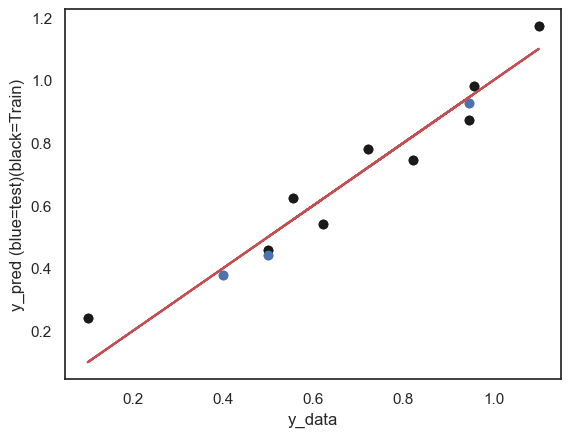

In [34]:
# LINEAR REGRESSION 
from sklearn.linear_model import LinearRegression

model = LinearRegression().fit(X, Y)

# OUTPUT PREDICTIONS FOR TRAINING AND TEST SET 
yp_train = model.predict(x_train)
yp_test = model.predict(x_test)

plt.plot(y_train,yp_train ,"o", color='k')
plt.plot(y_test,yp_test ,"o", color='b')
plt.plot(y_train,y_train,"-", color='r')

plt.xlabel("y_data")
plt.ylabel("y_pred (blue=test)(black=Train)")

    
err1=100.0*np.mean(np.absolute((yp_train-y_train)/y_train))
err2=100.0*np.mean(np.absolute((yp_test-y_test)/y_test))

print(" train error:",err1)
print(" test error:" ,err2)

plt.show();